## Time Series-Sentiment forecasting

### Importing libraries

In [101]:
# import libraries
import numpy as np
import pandas as pd

#decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# dickey fuller test for stationarity
from statsmodels.tsa.stattools import acf,pacf,adfuller

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# plots
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

# Ljung-Box test for model goodness
import statsmodels.api as sm
# resampling
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")

## Importing dataset

In [102]:
cd_sent = pd.read_csv("C:/Users/sandp/Downloads/cd_data_final.csv")

In [103]:
cd_sent.head(2)

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,Sentiment,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin
0,A2LBDC9ZGSCAE6,0005164885,True,christmas tso goes together like rudolph santa,5.0,2018-02-22,TSO...what more do you need to know?,1519257600,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,7,46,5.7,0.0,1.0,2018,1,7,"(0, 100]"
1,A2ZB6AHRM0ZLLW,0005164885,True,good,4.0,2018-02-14,Four Stars,1518566400,"['CDs & Vinyl', 'Holiday & Wedding']","['This is a concept album all the way, with ta...",...,Positive,1,4,4.0,0.7,1.0,2018,1,1,"(0, 100]"


In [104]:
#Extracting month from date
cd_sent['date']=pd.to_datetime(cd_sent['date'])
cd_sent['Month'] = cd_sent['date'].dt.month 

In [105]:
cd_sent['title']=cd_sent['title'].replace(to_replace='<span id="parentalAdvisory" class="a-size-medium a-color-secondary a-text-normal"',value='parentalAdvisory',regex=True)
cd_sent['title']=cd_sent['title'].replace(to_replace='<span class="a-size-medium a-color-secondary a-text-normal"',value='parentalAdvisory',regex=True)
cd_sent['title'].value_counts()

parentalAdvisory                                      45002
Greatest Hits                                          3839
Ultimate Collection                                    1194
The Definitive Collection                              1152
Millennium Collection - 20th Century Masters           1079
                                                      ...  
Avalon: A Tribute To Mississippi John Hurt                1
Last Kiss: The Definitive Collection                      1
Two's Company: The Duets                                  1
Outro Lugar                                               1
Dream City - Essential Recordings Vol 2, 1997-2006        1
Name: title, Length: 52957, dtype: int64

In [106]:
cd_sent=cd_sent[cd_sent['title']=='parentalAdvisory']

In [216]:
#Resampling to make the sentiment class balanced
cd_pos = cd_sent[cd_sent['Sentiment']=='Positive']
cd_neu = cd_sent[cd_sent['Sentiment']=='Neutral']
cd_neg = cd_sent[cd_sent['Sentiment']=='Negative']
 

##  Postive sentiment

### Creating sentiment count 

In [108]:
cd_pos_count=cd_pos.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_pos_count

,asin,Month,Sentiment,sentiment_count
0,7799627174,1,Positive,1
1,7799627174,2,Positive,2
2,7799627174,4,Positive,1
3,7799627174,7,Positive,1
4,7799627174,11,Positive,1
...,...,...,...,...
10414,B01HC8ZLSI,7,Positive,1
10415,B01HC8ZLSI,9,Positive,2
10416,B01HC8ZLSI,10,Positive,3
10417,B01HC8ZLSI,11,Positive,1


In [109]:
# Merging created sentiment count with original data frame
cd_pos=pd.merge(cd_pos,cd_pos_count)

### Time series analysis

### Creating functions for time series

In [110]:
# stationarity check
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    print('pvalue:',pvalue)

    if pvalue < 0.05:
        msg = "Data is Stationary. Proceed to model building"
    else:
        msg = " Data is not Stationary. Make the data stationary before model building"

    return msg

# Decomposition
def tsa_comp(df):
    decomp = seasonal_decompose(df, period=12, model='additive')
    d_trend = decomp.trend
    d_seasonal = decomp.seasonal
    d_resid = decomp.resid
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,8), facecolor='linen')
    plt.suptitle('TIME SERIES COMPONENT ANALYSIS', fontweight='bold', size=20)
    ax1.plot(df, label='Actual Sales')
    ax2.plot(d_trend, label='Trend', c='green')
    ax3.plot(d_seasonal, label='Seasonal', c='orange')
    ax4.plot(d_resid, label='Irregularity', c='pink')
    fig.legend();
    
 # acf and pacf plots
def p_and_q(data):
    fig,ax=plt.subplots(1,2,figsize=(15,5))
    plot_acf(data,lags=20,ax=ax[0])
    plot_pacf(data,lags=20,ax=ax[1]);

### Data preparation

In [111]:
cd_pos=cd_pos[['date','sentiment_count']]
cd_pos=cd_pos.set_index('date')
cd_pos=cd_pos.sort_values(by=['date'])
cd_pos

,sentiment_count
date,
1998-02-18,24
1998-02-19,16
1998-03-17,8
1998-03-26,4
1998-03-27,6
...,...
2018-05-12,3
2018-05-13,2
2018-05-13,2


### Resampling month wise

In [112]:
cd_pos=cd_pos.resample('M').mean()
cd_pos.head()

,sentiment_count
date,
1998-02-28,20.000000
1998-03-31,6.000000
1998-04-30,12.333333
1998-05-31,3.000000
1998-06-30,9.333333


In [113]:
cd_pos.tail()

,sentiment_count
date,
2018-03-31,12.957447
2018-04-30,9.954545
2018-05-31,6.000000
2018-06-30,NaN
2018-07-31,9.000000


In [114]:
cd_pos.isnull().sum()

sentiment_count    1
dtype: int64

In [115]:
cd_pos.dropna(inplace=True)

### Decomposition

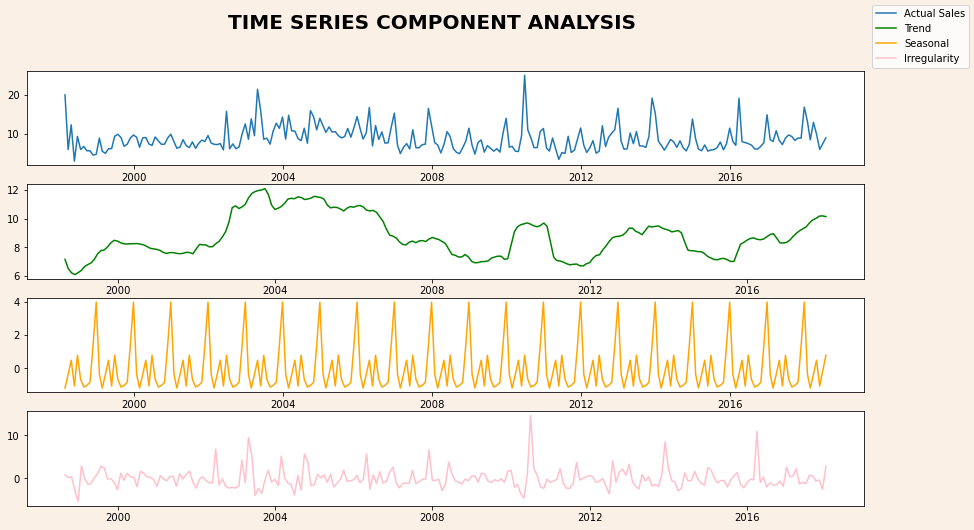

In [116]:
tsa_comp(cd_pos)

### Checking stationarity

In [117]:
checkStationarity(cd_pos)

pvalue: 0.11551329279986888


' Data is not Stationary. Make the data stationary before model building'

In [118]:
diff_cd_pos = cd_pos-cd_pos.shift(1)
print(diff_cd_pos)

            sentiment_count
date                       
1998-02-28              NaN
1998-03-31       -14.000000
1998-04-30         6.333333
1998-05-31        -9.333333
1998-06-30         6.333333
...                     ...
2018-02-28        -4.698505
2018-03-31         4.493161
2018-04-30        -3.002901
2018-05-31        -3.954545
2018-07-31         3.000000

[245 rows x 1 columns]


In [119]:
diff_cd_pos.dropna(inplace=True)

In [120]:
checkStationarity(diff_cd_pos)

pvalue: 2.486218987051444e-15


'Data is Stationary. Proceed to model building'

### Splitting the data

In [121]:
ratio = 0.7
rows = int(ratio * len(cd_pos))
train1 =cd_pos[:rows]
test1 = cd_pos[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_pos), len(train1), len(test1)))

Total=245, Train=171, Test=74


### PACF and ACF plots

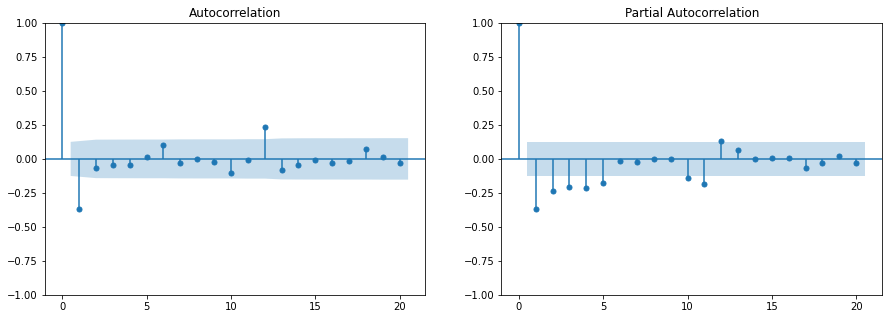

In [126]:
p_and_q(diff_cd_pos)

### creating models for different values of p and q

In [155]:
d=0;
lis=[]
for p in range(6):
    for q in range(4):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train1, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model


In [156]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train1), end=len(train1)+len(test1)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test1, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",897.830290,904.113617,9.728098,3.118990
1,Model 1,"(0, 0, 1)",888.286854,897.711844,9.726619,3.118753
2,Model 2,"(0, 0, 2)",883.757845,896.324499,9.732645,3.119719
3,Model 3,"(0, 0, 3)",885.757745,901.466062,9.732827,3.119748
4,Model 4,"(1, 0, 0)",884.555837,893.980827,9.712246,3.116448
5,Model 5,"(1, 0, 1)",882.259342,894.825997,9.768177,3.125408
6,Model 6,"(1, 0, 2)",885.757752,901.466070,9.732803,3.119744
7,Model 7,"(1, 0, 3)",883.201737,902.051718,9.788922,3.128725
8,Model 8,"(2, 0, 0)",884.370396,896.937051,9.684480,3.111990
9,Model 9,"(2, 0, 1)",885.396298,901.104616,9.694635,3.113621


In [157]:
print('Taking model with lowest RMSE score:')
df_results[df_results.RMSE==df_results.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
8,Model 8,"(2, 0, 0)",884.370396,896.937051,9.68448,3.11199


In [158]:
print('Taking model with lowest BIC score:')

df_results[df_results.BIC==df_results.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
4,Model 4,"(1, 0, 0)",884.555837,893.980827,9.712246,3.116448


In [159]:
print('Taking model with lowest AIC score:')
df_results[df_results.AIC==df_results.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
15,Model 15,"(3, 0, 3)",875.607313,900.740622,9.710349,3.116143


### Modelling

In [160]:
p=3;q=3;d=0
P=1;Q=1;D=0
m1 = sm.tsa.statespace.SARIMAX(cd_pos['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  245
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -611.629
Date:                              Wed, 25 Jan 2023   AIC                           1241.257
Time:                                      15:32:42   BIC                           1272.769
Sample:                                           0   HQIC                          1253.947
                                              - 245                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4040      0.572      0.706      0.480      -0.717       1.525
ar.L2          0.9516      0.284      3.351      0.001       0.395       1.508
ar.L3         -0.3618      0.411     -0.881      0.378      -1.167       0.443
ma.L1         -0.1233      0.577     -0.214      0.831      -1.254       1.008
ma.L2         -0.9107      0.176     -5.162      0.000      -1.256      -0.565
ma.L3          0.1558      0.401      0.389      0.697      -0.629       0.941
ar.S.L12       0.9599      0.059     16.405      0.000       0.845       1.075
ma.S.L12      -0.8303      0.121     -6.839      0.000      -1.068      -0.592
sigma2         8.3089      0.474     17.518      0.000       7.379       9.239
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               568.05
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             1.60
Prob(H) (two-sided):                  0.10   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [162]:
start = len(train1) 
end = len(train1) + len(test1) - 1

print('start = {}, end = {}'.format(start,end))

start = 171, end = 244


In [163]:
predictions = m1.predict(start,end)
predictions.index=test1.index
print(predictions)

date
2012-05-31     6.636813
2012-06-30     8.641393
2012-07-31     5.607919
2012-08-31     7.838036
2012-09-30     6.504898
                ...    
2018-02-28     9.274022
2018-03-31    10.051073
2018-04-30    10.072458
2018-05-31     8.679884
2018-07-31     9.127434
Name: predicted_mean, Length: 74, dtype: float64


In [164]:
actual = []; pred = []
test1.reset_index(drop=True)
for i in range(len(predictions)):
    actual.append(test1['sentiment_count'][i])
    pred.append(predictions[i])

df_res1 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res1['error'] = df_res1.actual - df_res1.predicted
df_res1.index=test1.index
print(df_res1)

               actual  predicted     error
date                                      
2012-05-31   5.045455   6.636813 -1.591358
2012-06-30   5.552239   8.641393 -3.089154
2012-07-31  12.091743   5.607919  6.483824
2012-08-31   6.741573   7.838036 -1.096463
2012-09-30   9.129412   6.504898  2.624514
...               ...        ...       ...
2018-02-28   8.464286   9.274022 -0.809737
2018-03-31  12.957447  10.051073  2.906374
2018-04-30   9.954545  10.072458 -0.117913
2018-05-31   6.000000   8.679884 -2.679884
2018-07-31   9.000000   9.127434 -0.127434

[74 rows x 3 columns]


In [165]:
mse1=mean_squared_error(df_res1.actual,df_res1.predicted)
rmse1=np.sqrt(mse1)
print('mse:',mse1)
print('rmse:',rmse1)

mse: 7.0887736726621835
rmse: 2.66247510273095


Text(0.5, 1.0, 'SARIMA Model. Order=(3,0,3)')

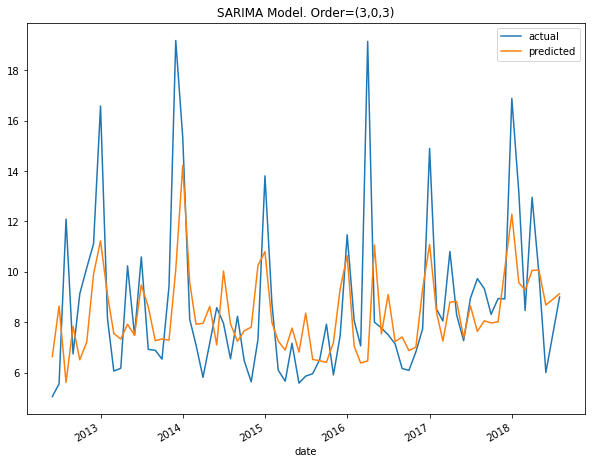

In [166]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res1.actual.plot(figsize=(10,8),legend=True)
df_res1.predicted.plot(legend=True)
plt.title(msg)

In [212]:
future_dates=pd.DataFrame()
future_dates['date']=[    
'2018-07-31',    
'2018-10-31',  
'2018-12-30',  
'2019-01-31',    
'2019-03-30',   
'2019-05-31',    
'2019-07-30',    
]      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [213]:
fcast1 = m1.predict(end,end+6).rename('Forecast')
fcast1.index=future_dates.date
print(fcast1.head())

date
2018-07-31    8.649253
2018-10-31    7.633219
2018-12-30    8.053921
2019-01-31    7.970040
2019-03-30    8.014399
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of positive sentiment'>

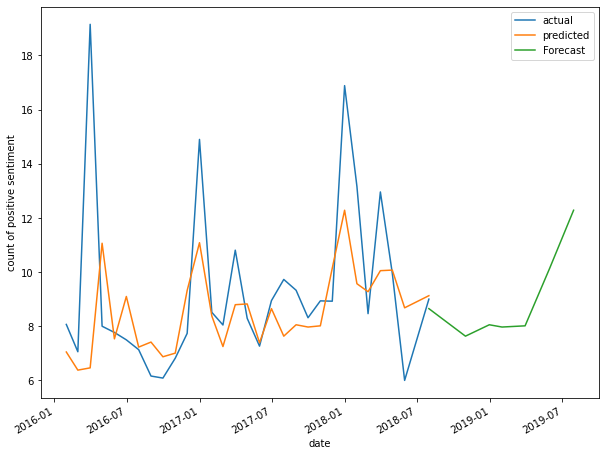

In [214]:
df_res1.actual.tail(30).plot(figsize=(10,8),legend=True)
df_res1.predicted.tail(30).plot(legend=True)
plt.ylabel('count of positive sentiment')
fcast1.plot(legend=True)

## Neutral Sentiment

In [217]:
cd_neu.head(3)

,reviewerID,asin,verified,review,ratings,date,summary,unixReviewTime,category,description,...,word_count,char_count,avg_word,polarity,label,year,rating_class_num,review_length,review_length_bin,Month
4306,A1GIIPXONCEEHP,7799627174,False,elvis valentines day offering certainly less f...,3.0,2005-02-01,+ 1/2 stars...For Romantics Only,1107216000,"['CDs & Vinyl', 'Pop', 'Oldies']",['ASIAN IMPORT FROM BMG/SONY. SEALED SHIPS FIR...,...,77,568,6.4,0.255556,0.0,2005,1,77,"(0, 100]",2
4382,A2XFJMYT2S05SR,807232053X,False,great idea carol lost voice,3.0,2014-11-04,Three Stars,1415059200,"['CDs & Vinyl', 'Rock', 'Folk Rock']",['KING CAROLE & TAYLOR JAMES-LIVE AT THE TROUB...,...,5,27,4.6,0.800000,0.0,2014,1,5,"(0, 100]",11
4383,A11FM1J5FMQPHR,807232053X,True,skips sometimes reverts,3.0,2014-10-21,Three Stars,1413849600,"['CDs & Vinyl', 'Rock', 'Folk Rock']",['KING CAROLE & TAYLOR JAMES-LIVE AT THE TROUB...,...,5,25,7.0,0.000000,0.0,2014,1,3,"(0, 100]",10


In [218]:
cd_neu['title'].value_counts()

parentalAdvisory    4579
Name: title, dtype: int64

In [219]:
cd_neu_count=cd_neu.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_neu_count

,asin,Month,Sentiment,sentiment_count
0,7799627174,2,Neutral,1
1,807232053X,5,Neutral,1
2,807232053X,6,Neutral,1
3,807232053X,9,Neutral,1
4,807232053X,10,Neutral,1
...,...,...,...,...
3080,B01GVQWS4C,9,Neutral,5
3081,B01GVQWS4C,10,Neutral,1
3082,B01GVQWS4C,11,Neutral,2
3083,B01HC8ZLSI,9,Neutral,1


In [220]:
cd_neu=pd.merge(cd_neu,cd_neu_count)

In [221]:
cd_neu=cd_neu[['date','sentiment_count']]
cd_neu=cd_neu.set_index('date')
cd_neu=cd_neu.sort_values(by=['date'])
cd_neu

,sentiment_count
date,
1998-08-03,1
1998-11-09,1
1998-11-24,1
1998-11-27,1
1998-11-27,1
...,...
2018-04-05,1
2018-04-14,1
2018-04-17,1


In [222]:
cd_neu=cd_neu.resample('M').mean()
cd_neu.head()

,sentiment_count
date,
1998-08-31,1.0
1998-09-30,NaN
1998-10-31,NaN
1998-11-30,1.2
1998-12-31,2.0


In [223]:
cd_neu.isnull().sum()

sentiment_count    4
dtype: int64

In [224]:
cd_neu.dropna(inplace=True)

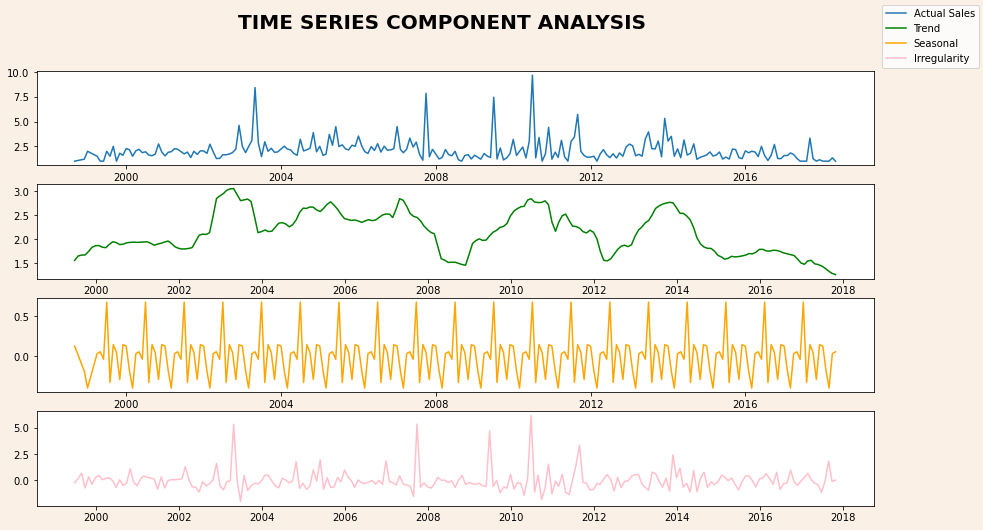

In [225]:
tsa_comp(cd_neu)

In [226]:
checkStationarity(cd_neu)

pvalue: 0.03557398426340664


'Data is Stationary. Proceed to model building'

In [227]:
ratio = 0.7
rows = int(ratio * len(cd_neu))
train2 =cd_neu[:rows]
test2 = cd_neu[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_neu), len(train2), len(test2)))

Total=233, Train=163, Test=70


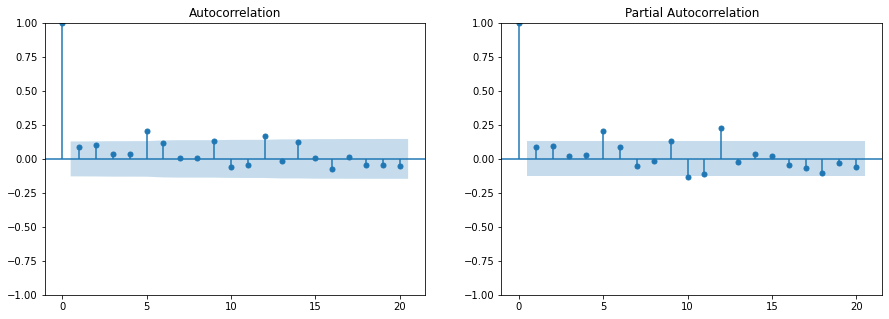

In [228]:
p_and_q(cd_neu)

In [266]:
d=0;
lis=[]
for p in range(6):
    for q in range(5):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train2, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model
Model 26 Good model
Model 27 Good model
Model 28 Good model
Model 29 Good model
Model 30 Good model


In [267]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train2), end=len(train2)+len(test2)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test2, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results2 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results2

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",538.874769,545.062269,0.775471,0.880608
1,Model 1,"(0, 0, 1)",540.706198,549.987448,0.774878,0.880272
2,Model 2,"(0, 0, 2)",542.391013,554.766014,0.772870,0.879130
3,Model 3,"(0, 0, 3)",544.363037,559.831788,0.773185,0.879309
4,Model 4,"(0, 0, 4)",546.082341,564.644842,0.775311,0.880518
5,Model 5,"(1, 0, 0)",540.692077,549.973328,0.774775,0.880213
6,Model 6,"(1, 0, 1)",541.946736,554.321737,0.764872,0.874570
7,Model 7,"(1, 0, 2)",544.381991,559.850742,0.772933,0.879166
8,Model 8,"(1, 0, 3)",546.355148,564.917649,0.773298,0.879374
9,Model 9,"(1, 0, 4)",546.303329,567.959580,0.776105,0.880968


In [268]:
print('Taking model with lowest RMSE score:')
df_results2[df_results2.RMSE==df_results2.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
29,Model 29,"(5, 0, 4)",541.630478,575.66173,0.7617,0.872754


In [269]:
print('Taking model with lowest BIC score:')

df_results2[df_results2.BIC==df_results2.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",538.874769,545.062269,0.775471,0.880608


In [270]:
print('Taking model with lowest AIC score:')
df_results2[df_results2.AIC==df_results2.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
17,Model 17,"(3, 0, 2)",535.610234,557.266486,0.797563,0.893064


In [289]:
p=4;q=2;d=0
P=1;Q=1;D=0
m2 = sm.tsa.statespace.SARIMAX(cd_neu['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                      sentiment_count   No. Observations:                  233
Model:             SARIMAX(4, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -358.125
Date:                              Wed, 25 Jan 2023   AIC                            734.251
Time:                                      15:49:12   BIC                            765.310
Sample:                                           0   HQIC                           746.775
                                              - 233                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0562      0.092      0.610      0.542      -0.124       0.237
ar.L2          1.0224      0.098     10.475      0.000       0.831       1.214
ar.L3         -0.0276      0.077     -0.356      0.722      -0.179       0.124
ar.L4         -0.0532      0.096     -0.551      0.582      -0.242       0.136
ma.L1          0.0392      0.054      0.726      0.468      -0.067       0.145
ma.L2         -0.9370      0.053    -17.830      0.000      -1.040      -0.834
ar.S.L12       0.4735      0.387      1.224      0.221      -0.285       1.232
ma.S.L12      -0.3349      0.390     -0.859      0.390      -1.099       0.429
sigma2         1.2540      0.062     20.150      0.000       1.132       1.376
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2369.60
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             3.14
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [290]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m2.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [291]:
start = len(train2) 
end = len(train2) + len(test2) - 1

print('start = {}, end = {}'.format(start,end))

start = 163, end = 232


In [292]:
predictions = m2.predict(start,end)
predictions.index=test2.index
print(predictions)

date
2012-07-31    2.276397
2012-08-31    2.347922
2012-09-30    1.963872
2012-10-31    1.649206
2012-11-30    2.050493
                ...   
2017-12-31    1.515500
2018-01-31    1.548221
2018-02-28    1.471615
2018-03-31    1.485677
2018-04-30    1.357817
Name: predicted_mean, Length: 70, dtype: float64


In [293]:
actual = []; pred = []
for i in range(len(predictions)):
    actual.append(test2['sentiment_count'][i])
    pred.append(predictions[i])

df_res2 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res2['error'] = df_res2.actual - df_res2.predicted
df_res2.index=test2.index
print(df_res2)

              actual  predicted     error
date                                     
2012-07-31  1.750000   2.276397 -0.526397
2012-08-31  1.307692   2.347922 -1.040230
2012-09-30  1.833333   1.963872 -0.130538
2012-10-31  1.500000   1.649206 -0.149206
2012-11-30  2.428571   2.050493  0.378078
...              ...        ...       ...
2017-12-31  1.000000   1.515500 -0.515500
2018-01-31  1.000000   1.548221 -0.548221
2018-02-28  1.000000   1.471615 -0.471615
2018-03-31  1.333333   1.485677 -0.152343
2018-04-30  1.000000   1.357817 -0.357817

[70 rows x 3 columns]


In [294]:
mse2=mean_squared_error(df_res2.actual,df_res2.predicted)
rmse2=np.sqrt(mse2)
print('mse:',mse2)
print('rmse:',rmse2)

mse: 0.5507129683521452
rmse: 0.7421003761972805


Text(0.5, 1.0, 'SARIMA Model. Order=(4,0,2)')

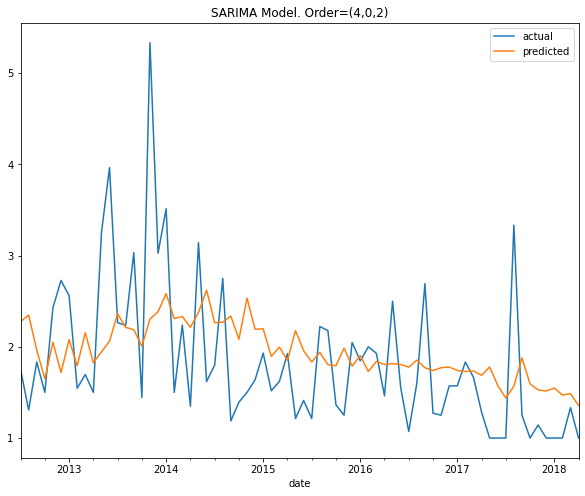

In [261]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res2.actual.plot(figsize=(10,8),legend=True)
df_res2.predicted.plot(legend=True)
plt.title(msg)

In [262]:
future_dates=pd.DataFrame()
future_dates['date']=[    
'2018-04-30',    
'2018-07-31',  
'2018-11-30',  
'2019-01-31',    
'2019-03-30',   
'2019-05-31',    
'2019-07-30',    
]      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)


In [263]:
fcast2 = m2.predict(end,end+6).rename('Forecast')
fcast2.index=future_dates.date
print(fcast2.head())

date
2018-04-30    1.357817
2018-07-31    1.407471
2018-11-30    1.316971
2019-01-31    1.346393
2019-03-30    1.676420
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of neutral sentiment'>

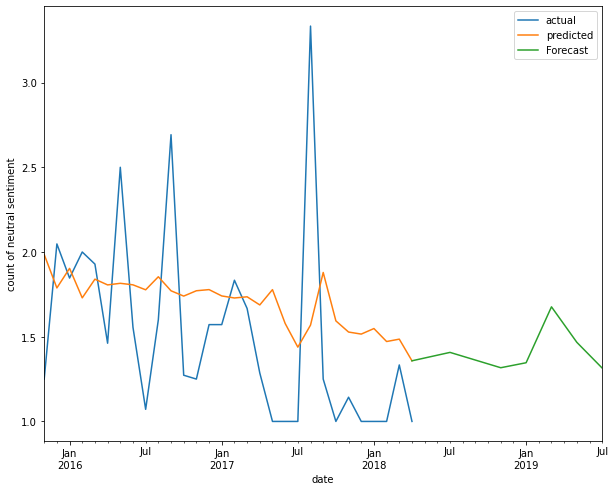

In [297]:
df_res2.actual.tail(30).plot(figsize=(10,8),legend=True)
df_res2.predicted.tail(30).plot(legend=True)
plt.ylabel('count of neutral sentiment')
fcast2.plot(legend=True)

## Negative

In [298]:
cd_neg_count=cd_neg.groupby(['asin','Month','Sentiment']).size().reset_index(name='sentiment_count')
cd_neg_count

,asin,Month,Sentiment,sentiment_count
0,7883938797,6,Negative,1
1,807232053X,2,Negative,1
2,807232053X,5,Negative,1
3,B00000010R,3,Negative,1
4,B00000010R,5,Negative,1
...,...,...,...,...
3085,B01GVQWS4C,10,Negative,5
3086,B01GVQWS4C,11,Negative,2
3087,B01HC8ZLSI,9,Negative,3
3088,B01HC8ZLSI,10,Negative,2


In [299]:
cd_neg=pd.merge(cd_neg,cd_neg_count)

In [300]:
cd_neg=cd_neg[['date','sentiment_count']]
cd_neg=cd_neg.set_index('date')
cd_neg=cd_neg.sort_values(by=['date'])
cd_neg

,sentiment_count
date,
1998-06-29,4
1998-06-29,1
1998-09-23,1
1998-10-02,1
1998-11-25,1
...,...
2018-03-04,1
2018-03-07,2
2018-04-25,3


In [301]:
cd_neg=cd_neg.resample('M').mean()
cd_neg.head()

,sentiment_count
date,
1998-06-30,2.5
1998-07-31,NaN
1998-08-31,NaN
1998-09-30,1.0
1998-10-31,1.0


In [302]:
cd_neg.isnull().sum()

sentiment_count    4
dtype: int64

In [303]:
cd_neg.dropna(inplace=True)

In [304]:
checkStationarity(cd_neg)

pvalue: 0.001971790780439436


'Data is Stationary. Proceed to model building'

In [305]:
ratio = 0.7
rows = int(ratio * len(cd_neg))
train3 =cd_neg[:rows]
test3 = cd_neg[rows:]

print("Total={}, Train={}, Test={}".format(len(cd_neg), len(train3), len(test3)))

Total=237, Train=165, Test=72


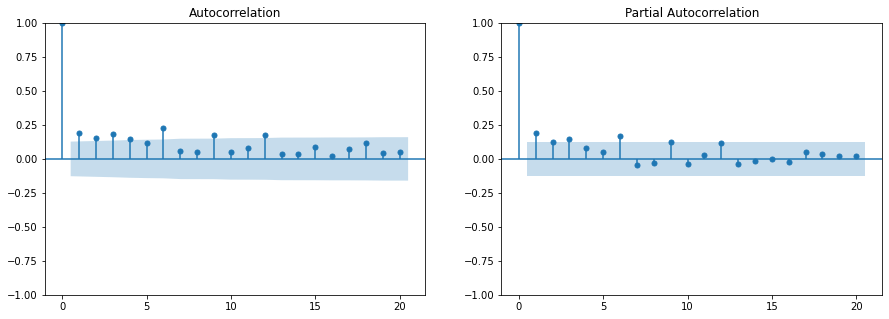

In [306]:
p_and_q(cd_neg)

In [307]:
d=0;
lis=[]
for p in range(5):
    for q in range(5):
        lis.append((p,d,q))

# building model
model=[]
for i in lis:
    m =ARIMA(train3, order=i).fit() 
    model.append(m)

# checking model is good or not
model_st=[]
c=1
for i in model:
    pvalue = sm.stats.acorr_ljungbox(i.resid, lags=[1], return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print(f'Model {c} Not a good model')
    else:
        print(f'Model {c} Good model')
    c+=1

Model 1 Not a good model
Model 2 Good model
Model 3 Good model
Model 4 Good model
Model 5 Good model
Model 6 Good model
Model 7 Good model
Model 8 Good model
Model 9 Good model
Model 10 Good model
Model 11 Good model
Model 12 Good model
Model 13 Good model
Model 14 Good model
Model 15 Good model
Model 16 Good model
Model 17 Good model
Model 18 Good model
Model 19 Good model
Model 20 Good model
Model 21 Good model
Model 22 Good model
Model 23 Good model
Model 24 Good model
Model 25 Good model


In [308]:
aic=[]
bic=[]
for i in model[0:]:
    aic.append(i.aic)
    bic.append(i.bic)

# predicting values
forecast=[]
for i in model[0:]:
    fcast = i.predict(start=len(train3), end=len(train3)+len(test3)-1)
    forecast.append(fcast)

# calculating MSE and RMSE score
MSE = []
RMSE = []
for i in forecast:
    mse = mean_squared_error(test3, i)
    rmse = np.sqrt(mse)
    MSE.append(mse)
    RMSE.append(rmse)

# printing model numbers
model_no=[]
for i in range(0,len(model)):
    model_no.append('Model '+str(i))
    
# dataframe of all results
df_results3 = pd.DataFrame({'Model No.': model_no, '(p, d, q)':lis[0:], 'AIC': aic, 'BIC': bic, 'MSE': MSE, 'RMSE': RMSE})
df_results3

,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
0,Model 0,"(0, 0, 0)",899.168662,905.380553,7.989657,2.826598
1,Model 1,"(0, 0, 1)",898.213129,907.530965,7.975650,2.824119
2,Model 2,"(0, 0, 2)",897.471984,909.895766,7.971405,2.823368
3,Model 3,"(0, 0, 3)",895.917787,911.447514,7.965450,2.822313
4,Model 4,"(0, 0, 4)",897.461807,916.097479,7.947411,2.819115
5,Model 5,"(1, 0, 0)",897.366079,906.683915,7.968001,2.822765
6,Model 6,"(1, 0, 1)",889.184697,901.608479,7.418610,2.723713
7,Model 7,"(1, 0, 2)",891.040157,906.569884,7.461378,2.731552
8,Model 8,"(1, 0, 3)",893.029977,911.665650,7.451574,2.729757
9,Model 9,"(1, 0, 4)",894.680151,916.421769,7.413704,2.722812


In [309]:
print('Taking model with lowest RMSE score:')
df_results3[df_results3.RMSE==df_results3.RMSE.min()]


Taking model with lowest RMSE score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
24,Model 24,"(4, 0, 4)",892.335764,923.395219,7.244938,2.691642


In [310]:
print('Taking model with lowest BIC score:')

df_results3[df_results3.BIC==df_results3.BIC.min()]

Taking model with lowest BIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
6,Model 6,"(1, 0, 1)",889.184697,901.608479,7.41861,2.723713


In [311]:
print('Taking model with lowest AIC score:')
df_results3[df_results3.AIC==df_results3.AIC.min()]

Taking model with lowest AIC score:


,Model No.,"(p, d, q)",AIC,BIC,MSE,RMSE
18,Model 18,"(3, 0, 3)",884.688395,909.535959,7.360035,2.712938


In [326]:
p=1;q=1;d=0
P=1;Q=1;D=0
m3 = sm.tsa.statespace.SARIMAX(cd_neg['sentiment_count'],order=(p,d,q),seasonal_order=(P,D,Q,12)).fit()
# summarise the model
m3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                    sentiment_count   No. Observations:                  237
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -615.798
Date:                            Wed, 25 Jan 2023   AIC                           1241.596
Time:                                    15:53:34   BIC                           1258.936
Sample:                                         0   HQIC                          1248.585
                                            - 237                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.012     82.937      0.000       0.968       1.015
ma.L1         -0.8831      0.040    -22.057      0.000      -0.962      -0.805
ar.S.L12       0.5228      0.653      0.801      0.423      -0.757       1.802
ma.S.L12      -0.4228      0.757     -0.558      0.577      -1.907       1.061
sigma2        10.4924      0.341     30.736      0.000       9.823      11.161
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):             17863.59
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             5.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [327]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [328]:
start = len(train3) 
end = len(train3) + len(test3) - 1

print('start = {}, end = {}'.format(start,end))

start = 165, end = 236


In [329]:
predictions = m3.predict(start,end)
predictions.index=test3.index
print(predictions)

date
2012-06-30    2.636105
2012-07-31    2.231299
2012-08-31    3.196336
2012-09-30    2.585658
2012-10-31    2.264367
                ...   
2018-01-31    1.981109
2018-03-31    1.910235
2018-04-30    1.760215
2018-05-31    2.086282
2018-06-30    2.040311
Name: predicted_mean, Length: 72, dtype: float64


In [330]:
actual = []; pred = []
for i in range(len(predictions)):
    actual.append(test3['sentiment_count'][i])
    pred.append(predictions[i])

df_res3 = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res3['error'] = df_res3.actual - df_res3.predicted
df_res3.index=test3.index
print(df_res3)

              actual  predicted     error
date                                     
2012-06-30  1.923077   2.636105 -0.713028
2012-07-31  3.875000   2.231299  1.643701
2012-08-31  4.000000   3.196336  0.803664
2012-09-30  1.375000   2.585658 -1.210658
2012-10-31  1.809524   2.264367 -0.454843
...              ...        ...       ...
2018-01-31  1.500000   1.981109 -0.481109
2018-03-31  1.666667   1.910235 -0.243568
2018-04-30  3.000000   1.760215  1.239785
2018-05-31  3.000000   2.086282  0.913718
2018-06-30  1.000000   2.040311 -1.040311

[72 rows x 3 columns]


In [331]:
mse3=mean_squared_error(df_res3.actual,df_res3.predicted)
rmse3=np.sqrt(mse3)
print('mse:',mse3)
print('rmse:',rmse3)

mse: 6.6279522849823325
rmse: 2.5744809739017946


Text(0.5, 1.0, 'SARIMA Model. Order=(1,0,1)')

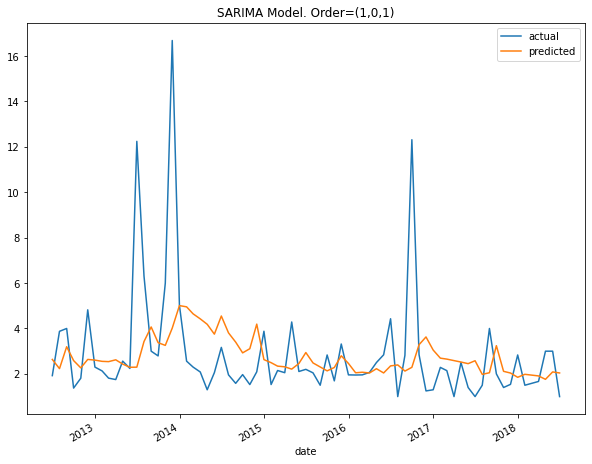

In [332]:
msg = 'SARIMA Model. Order=(' + str(p) + ',' + str(d) + ',' + str(q) + ')'
df_res3.actual.plot(figsize=(10,8),legend=True)
df_res3.predicted.plot(legend=True)
plt.title(msg)

In [336]:
future_dates=pd.DataFrame()
future_dates['date']=[     
'2018-06-30',    
'2018-09-30',       
'2018-12-31',     
'2019-01-31',   
'2019-03-30',
'2019-05-31',
'2019-07-31']      
future_dates=pd.to_datetime(future_dates['date'])
future_dates=pd.DataFrame(future_dates)

In [337]:
fcast3 = m3.predict(end,end+6).rename('Forecast')
fcast3.index=future_dates.date
print(fcast3.head())

date
2018-06-30    2.040311
2018-09-30    1.982646
2018-12-31    1.844585
2019-01-31    2.139989
2019-03-30    2.347157
Name: Forecast, dtype: float64


<AxesSubplot:xlabel='date', ylabel='count of negative sentiment'>

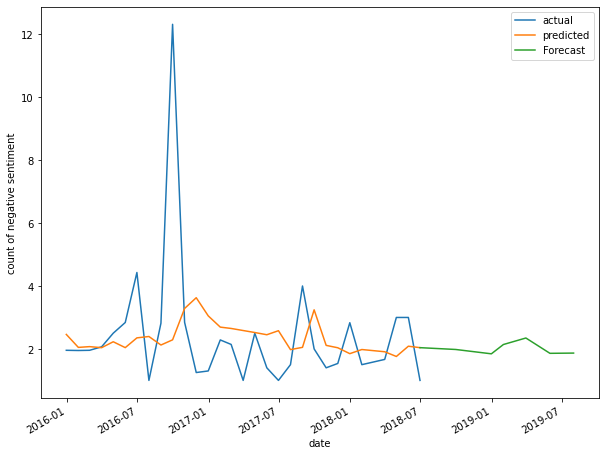

In [338]:
df_res3.actual.tail(30).plot(figsize=(10,8),legend=True)
df_res3.predicted.tail(30).plot(legend=True)
plt.ylabel('count of negative sentiment')
fcast3.plot(legend=True)

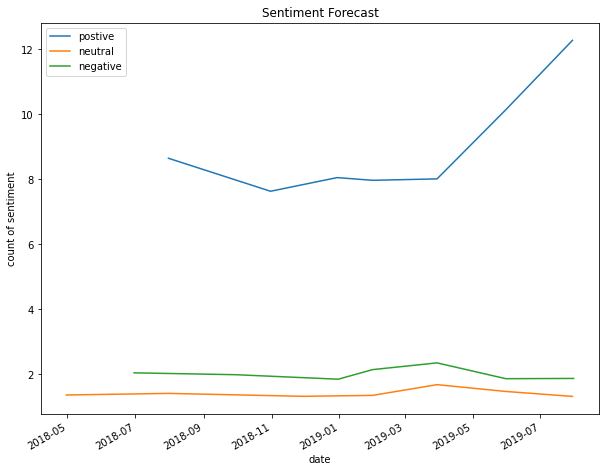

In [345]:
plt.figure(figsize=(10,8))
plt.title('Sentiment Forecast')
plt.ylabel('count of sentiment')
fcast1.plot(label='postive')
fcast2.plot(label='neutral')
fcast3.plot(label='negative')
plt.legend()